# ELASTIC-NET (SQRT Transformed)

In [102]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate,GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [103]:
df = pd.read_csv('clean_and_encoded_df.csv')

# Apply the square root function to the Annual_salary column
df['Annual_salary'] = np.sqrt(df['Annual_salary'])

# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep = [col for col in df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_df = df[columns_to_keep]


baseline_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Andorra,Country_Angola,Country_Argentina,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,4.8,200.511845
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,6.4,229.715041
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,232.432786
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.8,268.780580
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,11.4,250.639183


Baseline model:

In [104]:
base_X = baseline_df.drop('Annual_salary', axis=1)
y = baseline_df['Annual_salary']
print(base_X.shape)
print(y.shape)

(2805, 138)
(2805,)


In [105]:
X_train, X_test, y_train, y_test = train_test_split(base_X, y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [106]:
'''from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Create the ElasticNet model object
enet = ElasticNet(random_state=42)

# Define the parameter search space
param_dist = {
    'alpha': uniform(loc=0, scale=1000),  # Alpha search range from 0 to 1000
    'l1_ratio': uniform(loc=0, scale=1)   # L1_ratio search range from 0 to 1
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    enet, param_distributions=param_dist, n_iter=100,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best parameters found for ElasticNet:")
print(random_search.best_params_)'''


'from sklearn.linear_model import ElasticNet\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform\n\n# Create the ElasticNet model object\nenet = ElasticNet(random_state=42)\n\n# Define the parameter search space\nparam_dist = {\n    \'alpha\': uniform(loc=0, scale=1000),  # Alpha search range from 0 to 1000\n    \'l1_ratio\': uniform(loc=0, scale=1)   # L1_ratio search range from 0 to 1\n}\n\n# Create the RandomizedSearchCV object\nrandom_search = RandomizedSearchCV(\n    enet, param_distributions=param_dist, n_iter=100,\n    scoring=\'neg_mean_squared_error\', n_jobs=-1, cv=5, random_state=42\n)\n\n# Fit the RandomizedSearchCV object to the training data\nrandom_search.fit(X_train_scaled, y_train)\n\n# Print the best parameters\nprint("Best parameters found for ElasticNet:")\nprint(random_search.best_params_)'

In [107]:
# With ADJ R2

enet = ElasticNet(alpha=0.5, l1_ratio=0.95, random_state=42)

k = 5
num_val_samples = len(X_train_scaled) // k
all_scores_r2 = []
all_scores_adjusted_r2 = []
all_scores_rmse = []
all_scores_mae = []

for i in range(k):
    print('processing fold #', i)
    
    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train_scaled[:i * num_val_samples],
         X_train_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    enet.fit(partial_train_data, partial_train_targets)

    val_preds = enet.predict(val_data)
    # Reverse sqrt transformation
    val_preds_sqrd = val_preds**2 
    val_targets_sqrd = val_targets**2 

    r2_val = r2_score(val_targets_sqrd, val_preds_sqrd)
    n = val_data.shape[0]
    p = val_data.shape[1]
    adjusted_r2_val = 1 - (1 - r2_val) * (n - 1) / (n - p - 1)
    rmse_val = np.sqrt(mean_squared_error(val_targets_sqrd, val_preds_sqrd))
    mae_val = mean_absolute_error(val_targets_sqrd, val_preds_sqrd)

    all_scores_r2.append(r2_val)
    all_scores_adjusted_r2.append(adjusted_r2_val)
    all_scores_rmse.append(rmse_val)
    all_scores_mae.append(mae_val)


mean_r2 = np.mean(all_scores_r2)
std_r2 = np.std(all_scores_r2)
mean_adjusted_r2 = np.mean(all_scores_adjusted_r2)
std_adjusted_r2 = np.std(all_scores_adjusted_r2)
mean_rmse = np.mean(all_scores_rmse)
std_rmse = np.std(all_scores_rmse)
mean_mae = np.mean(all_scores_mae)
std_mae = np.std(all_scores_mae)

print(f"Average R2 score (ENet): {mean_r2:.3f} (+/- {std_r2:.3f})")
print(f"Average adjusted R2 score (ENet): {mean_adjusted_r2:.3f} (+/- {std_adjusted_r2:.3f})")
print(f"Average RMSE score (ENet): {mean_rmse:.3f} (+/- {std_rmse:.3f})")
print(f"Average MAE score (ENet): {mean_mae:.3f} (+/- {std_mae:.3f})")


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Average R2 score (ENet): 0.603 (+/- 0.016)
Average adjusted R2 score (ENet): 0.425 (+/- 0.023)
Average RMSE score (ENet): 31874.838 (+/- 1328.134)
Average MAE score (ENet): 23134.642 (+/- 1126.394)


In [108]:
elasticnet_results_dic = {}
elasticnet_results_dic['ElasticNet'] = {'R2': mean_r2, 'Adjusted R2': mean_adjusted_r2, 'RMSE': mean_rmse, 'MAE': mean_mae}
elasticnet_results = pd.DataFrame.from_dict(elasticnet_results_dic, orient='index')
elasticnet_results

,R2,Adjusted R2,RMSE,MAE
ElasticNet,0.602515,0.424997,31874.838071,23134.641984


In [109]:
elasticnet_results.to_csv('elasticnet_results.csv', index=True)

In [110]:
# Combinar conjuntos de datos de entrenamiento y validación
X_train_val = np.concatenate((X_train_scaled, val_data), axis=0)
y_train_val = np.concatenate((y_train, val_targets), axis=0)

# Entrenar el modelo utilizando el conjunto de datos combinado
enet.fit(X_train_val, y_train_val)

# Hacer predicciones en el conjunto de datos de prueba
y_pred = enet.predict(X_test_scaled)

# Revertir la transformación logarítmica
y_pred_sqrd = y_pred**2 #np.exp(y_pred)
y_test_sqrd = y_test**2 #np.exp(y_test)

# Calcular métricas de rendimiento en el conjunto de datos de prueba
r2_test = r2_score(y_test_sqrd, y_pred_sqrd)
rmse_test = np.sqrt(mean_squared_error(y_test_sqrd, y_pred_sqrd))
mae_test = mean_absolute_error(y_test_sqrd, y_pred_sqrd)
n_test = len(X_test_scaled)
p_test = X_train_val.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print(f"Average R2 score (ENet): {r2_test:.3f}")
print(f"Average adjusted R2 score (ENet): {adjusted_r2_test:.3f}")
print(f"Average RMSE score (ENet): {rmse_test:.3f}")
print(f"Average MAE score (ENet): {mae_test:.3f}")



Average R2 score (ENet): 0.606
Average adjusted R2 score (ENet): 0.478
Average RMSE score (ENet): 31814.911
Average MAE score (ENet): 23089.799


In [111]:
test_results_dic = {}
test_results_dic['ElasticNet'] = {'R2': r2_test,  'Adj R2': adjusted_r2_test, 'RMSE': rmse_test, 'MAE': mae_test}
test_results = pd.DataFrame.from_dict(test_results_dic, orient='index')
test_results

,R2,Adj R2,RMSE,MAE
ElasticNet,0.606339,0.477607,31814.910999,23089.79883


In [112]:
test_results.to_csv('sqrt_test_elasticnet_results.csv', index=True)

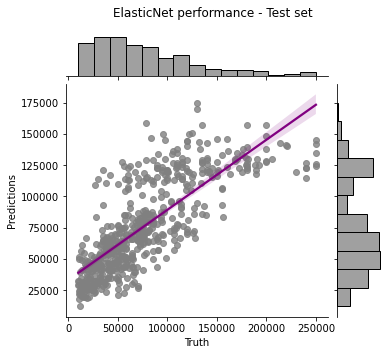

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a joint plot and configure the axes for the histograms
g = sns.JointGrid(x=y_test_sqrd, y=y_pred_sqrd, height=5)

# Create a scatter plot and fit a linear regression line to the data
g.plot_joint(sns.regplot, scatter_kws={'color': 'grey'}, line_kws={'color': 'purple'})

# Add histograms to the top and right side of the plot
g.plot_marginals(sns.histplot, kde=False, color='grey')

# Adjust the spacing between the subplots and move the title up
g.fig.subplots_adjust(top=0.9)

# Add a title
g.fig.suptitle("ElasticNet performance - Test set")

# Label the axes
g.ax_joint.set_xlabel("Truth")
g.ax_joint.set_ylabel("Predictions")

plt.show()

